# Online Phase: POD with Interpolation

**Aim of the tutorial:** this notebook shows how to perform the online phase of the POD with Interpolation (PODI) algorithm, i.e. how to use this method to reconstruct a field for an unseen input parameter.

In particular, the basis functions, generated offline by the POD, provide the spatial behaviour, whereas the parametric dependence is embedded in the reduced coefficients learnt through suitable maps (i.e., Linear or RBF Interpolation or Supervised Learning method such as the Gaussian Process Regression).

-------------------------------------------

*To execute this notebook* it is necessary to have the snapshots stored in `Snapshots` folder, placed in this directory (otherwise modify `path_FOM` variable) and to have the directory `Offline_results` containing the POD modes and the maps for the reduced coefficients.

In [1]:
import os
from IPython.display import clear_output
import numpy as np
import pickle

from dolfinx.fem import FunctionSpace
from pyforce.online.pod_interpolation import PODI
from pyforce.online.pod_projection import PODproject
import ufl

import matplotlib.pyplot as plt
from matplotlib import cm

from pyforce.tools.functions_list import FunctionsList, train_test_split
from pyforce.tools.write_read import ImportH5


path_off ='./Offline_results/'

The geometry can be either generated directly in this notebook or loaded from a file.

**Disclaimer**: we have noticed that the degrees of freedom (dofs) of the mesh can vary according to the adopted operating system: for instance, if run on MacOS the dofs are 2356, whereas on Linux machines they are 2385. This is due to the fact that the mesh is generated through the `gmsh` library, which can produce different results on different platforms. 

*If an error occurs, please check the number of dofs and adjust the code accordingly: if the snapshots have been download from [Zenodo](https://zenodo.org/records/11483677) it is suggested to load the `msh` file; otherwise, if the snapshots hase been generated locally, the `use_msh` option must be set to `False`.*

In [25]:
from ns import create_dfg2_mesh

# Snapshots downloaded
# domain = create_dfg2_mesh(mesh_factor=0.5, use_msh=True)[0]

# Snapshots generated locally
domain, _, ft, _ = create_dfg2_mesh(mesh_factor=0.5, use_msh=False, save_mesh=False)

clear_output()

## Importing Snapshots and offline results

The snapshots are loaded and stored into suitable data structures.

Defining the functional space

In [3]:
fun_spaces = [FunctionSpace(domain, ("Lagrange", 1)),
              FunctionSpace(domain, ufl.VectorElement("Lagrange", domain.ufl_cell(), 1))]

Defining the variables to load

In [4]:
var_names = [
             'p',
             'u'
             ]

tex_var_names = [
                 r'p',
                 r'\mathbf{u}'
                 ]

Let us load the snapshots from the approapriate folder and let us extract the test set using random split (be sure to use the same `random_state` of the offline phase, this condition is satisfied if `random_state` is not passed to `train_test_split`).

In [5]:
path_FOM = './Snapshots/'

test_snaps  = list()
test_params  = list()

for field_i in range(len(var_names)):

    tmp_FOM_list, tmp_param = ImportH5(fun_spaces[field_i], path_FOM+'snaps_'+var_names[field_i], var_names[field_i])
    
    res = train_test_split(tmp_param, tmp_FOM_list, test_size=0.25)

    test_params.append(np.array(res[1]).reshape(-1,1))
    test_snaps.append(res[3])
    
    del tmp_FOM_list, tmp_param

The POD modes are loaded using `ImportH5`.

In [6]:
pod_modes = [ImportH5(fun_spaces[field_i], 
                      path_off+'BasisFunctions/basisPOD_' + var_names[field_i],
                      'POD_' +var_names[field_i])[0] for field_i in range(len(var_names))]

Then, let us import the maps $t\longrightarrow \alpha_m(t)$

In [7]:
coeff_maps = pickle.load(open(path_off+'pod_coeff.maps', 'rb'))

## Online Phase
The test set related to unseen parameters are reconstruction using the Proper Orthogonal Decomposition with Intepolation, compared with the projection case.

### Test Error
Let us first define the structures for storing the errors and the computational time: a dictionary is used to store the errors for each map tested.

As maximum number of modes, we use the number of modes available $N_{max} = 30$.

In [8]:
test_results = dict()

Nmax = 30

assert Nmax <= len(pod_modes[0])
assert Nmax <= len(pod_modes[1])

Let us reconstruct the field using the POD projection, the coefficients are obtained by means of the following projection (scalar product in $L^2$) for an unseen parameter $\boldsymbol{\mu}^\star$:
\begin{equation*}
\alpha_m(\boldsymbol{\mu}^\star) = \int_{\Omega} u(\mathbf{x}; \boldsymbol{\mu}^\star)\cdot \psi_m\, d\Omega
\end{equation*}

This is the standard POD projection, which is used as a reference for the interpolation methods, acting as the best-case scenario: it cannot be adopted for real problems because it is assumed to know the actual FOM solution. This procedure is implemented in the `PODproject` class: the initialisation requires the POD modes and the name of the variable to be reconstructed.

Then, the method `synt_test_error` is used to compute the error for the unseen parameters: this requires the test snapshots for comparison and the number of modes to be used.

In [9]:
pod_proj_online = [PODproject(pod_modes[field_i], 
                              name=var_names[field_i]) for field_i in range(len(var_names))]

test_results['POD-Project'] = [ pod_proj_online[field_i].synt_test_error(test_snaps[field_i], Nmax, verbose=True) 
                                for field_i in range(len(var_names))]

Computing POD test error (projection) - p: 160.000 / 160.00 - 0.035 s/it
Computing POD test error (projection) - u: 160.000 / 160.00 - 0.046 s/it


The output of the previous cell is a list for each field reconstructed: there 2 elements in this case, since the fields to reconstruct are the pressure and the velocity.
The method `synt_test_error` produces a `namedtuple` with 3 elements:

- mean_abs_err
- mean_rel_err
- computational_time

The first two are list of floats, containing the mean absolute and relative errors for each field, respectively, defined as follows 
\begin{equation*}
\begin{split}
E_N[u] &= \left\langle \left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}\right\rangle_{\boldsymbol{\mu}\in\Xi^{test}}\\
\varepsilon_N[u] &= \left\langle\frac{\left\| u(\cdot;\,\boldsymbol{\mu}) - \mathcal{P}_N[u](\cdot;\,\boldsymbol{\mu})\right\|_{L^2(\Omega)}}{\left\| u(\cdot;\,\boldsymbol{\mu}) \right\|_{L^2(\Omega)}}\right\rangle_{\boldsymbol{\mu}\in\Xi^{test}}
\end{split}
\end{equation*}
given $\mathcal{P}_N$ the reconstruction operator with $N$ basis functions.

The last element is a dictionary with computational time required to perform the reconstruction.

In [10]:
print(test_results['POD-Project'][0]._fields)

('mean_abs_err', 'mean_rel_err', 'computational_time')


Then, let us use the POD with Interpolation in which the coefficients $\alpha_m(t)$ are estimated through a suitable map (e.g., interpolation). This procedure is implemented in the `PODI` class: the initialisation requires the POD modes, the maps and the name of the variable to be reconstructed.

Then, the method `synt_test_error` is used to compute the error for the unseen parameters: this requires the test snapshots for comparison and the number of modes to be used.

In [11]:
pod_i_online = dict()

print('---------------------------------------------------------------------------')

for key_i, key in enumerate(list(coeff_maps[0].keys())):
    
    print('PODI-'+key)
    
    pod_i_online[key] = [PODI(pod_modes[field], coeff_maps[field][key], 
                              name=var_names[field]) for field in range(len(var_names))]
    
    test_results['PODI-'+key] = [pod_i_online[key][field_i].synt_test_error(test_snaps[field_i], test_params[field_i], Nmax, verbose=True) 
                                for field_i in range(len(var_names))]
    print('---------------------------------------------------------------------------')

---------------------------------------------------------------------------
POD-LinInt
Computing POD test error (interpolation) - p: 160.000 / 160.00 - 0.025 s/it
Computing POD test error (interpolation) - u: 160.000 / 160.00 - 0.031 s/it
---------------------------------------------------------------------------
POD-RBF
Computing POD test error (interpolation) - p: 160.000 / 160.00 - 0.023 s/it
Computing POD test error (interpolation) - u: 160.000 / 160.00 - 0.026 s/it
---------------------------------------------------------------------------


Let us plot the error as a function of the basis rank. 

**Note on the results structure**: `test_results[key][field_i]` is a list of `namedtuple` with 3 elements, as described above. `key` is the name of algorithm used (i.e., *POD-project*,  *'PODI-LinInt'* and *'PODI-RBF*), `field_i` is the index of the field (i.e., *'pressure'* and *'velocity'*). In this cell, we plot the first two elements of the `namedtuple` for each field and each algorithm.

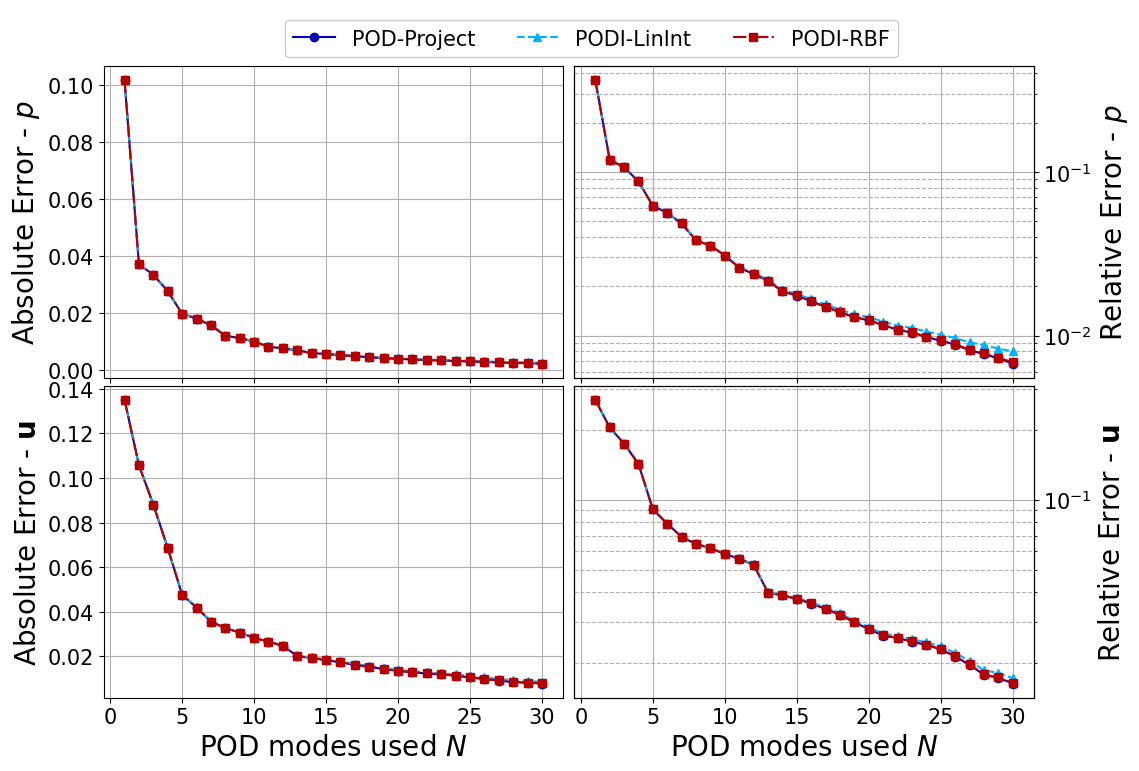

In [12]:
def plot_errors(var_names, Nmax, test_results):

    fig, axs = plt.subplots(nrows = 2, ncols = 2, sharex=True, figsize=(2 * 6, 2*4))

    N_plot = np.arange(1, Nmax+1, 1)
    fontsize  = 20
    labelsize = 15

    markers = ['o', '^', 's']
    lines_style = ['-', '--', '-.']
    colors = cm.jet([0.05, 0.3, 0.95])

    for field_i in range(len(var_names)):
        
        ax2 = axs[field_i, 1].twinx()
        for ii, key in enumerate(list(test_results.keys())):
            axs[field_i, 0].plot(N_plot, test_results[key][field_i][0], markers[ii]+lines_style[ii], c=colors[ii], label=key)
            ax2.semilogy(N_plot, test_results[key][field_i][1], markers[ii]+lines_style[ii], c=colors[ii], label=key)
            
        axs[field_i, 0].set_ylabel(r'Absolute Error - $'+tex_var_names[field_i]+r'$', fontsize=fontsize)
        ax2.set_ylabel(r'Relative Error - $'+tex_var_names[field_i]+r'$', fontsize=fontsize)
        
        axs[field_i, 0].grid(which='major',linestyle='-')
        axs[field_i, 0].grid(which='minor',linestyle='--')
        axs[field_i, 1].set_yticks([])
        axs[field_i, 1].grid(which='major',linestyle='-')
        axs[field_i, 1].grid(which='minor',linestyle='--')   
        ax2.grid(which='major',linestyle='-')
        ax2.grid(which='minor',linestyle='--')   
        ax2.tick_params(axis='both', labelsize=labelsize)

    for ax in axs.flatten():
        ax.tick_params(axis='both', labelsize=labelsize)
    axs[1, 0].set_xlabel(r'POD modes used $N$', fontsize=fontsize)
    axs[1, 1].set_xlabel(r'POD modes used $N$', fontsize=fontsize)    

    Line, Label = axs[0,0].get_legend_handles_labels()    
    fig.legend(Line, Label, framealpha = 1, fontsize=labelsize, loc=(0.25, 0.925), ncols=3)

    fig.subplots_adjust(hspace = 0.025, wspace=0.025, top=0.9)
    
    plt.show()
    
plot_errors(var_names, Nmax, test_results)

Let us also plot the computational costs.

**Note on the results structure**: `test_results[key][field_i][2]` contains the computational times, this is a dictionary with different entries. We are interested in showing the time required to estimate a coefficient, i.e. `test_results[key][field_i][2]['CoeffEstimation]`.

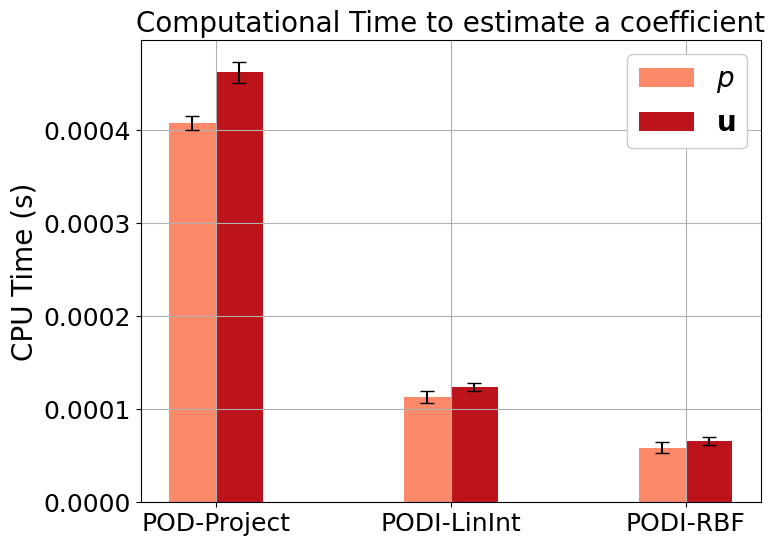

In [13]:
def plot_computational_times(var_names, test_results):

    # Initialize subplots
    fig, ax = plt.subplots(figsize=(8, 6))

    # Iterate over field_i values
    colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(var_names)))  # Choose a colormap
    for field_i, color in zip(range(len(var_names)), colors):
        means = []
        stds = []

        # Calculate mean and std for each key
        for key in list(test_results.keys()):
            mean = np.mean(np.mean(test_results[key][field_i][2]['CoeffEstimation'], axis=0))
            std = np.std(np.mean(test_results[key][field_i][2]['CoeffEstimation'], axis=0))
            means.append(mean)
            stds.append(std)

        # Plot the bar chart with error bars for standard deviation
        bar_width = 0.2  # Adjust as needed
        ind = np.arange(len(list(test_results.keys())))
        bars = ax.bar(ind + (field_i - len(var_names) / 4) * bar_width, means, bar_width, label=r'$'+tex_var_names[field_i]+'$', color=color, yerr=stds, capsize=5)

    ax.set_ylabel(r'CPU Time (s)', fontsize=20)
    ax.set_title(r'Computational Time to estimate a coefficient', fontsize=20)
    ax.set_xticks(ind)
    ax.set_xticklabels(list(test_results.keys()))
    ax.legend(framealpha=1, fontsize=20)
    ax.tick_params(axis='both', labelsize=18)
    ax.grid()
    
    plt.show()
    
plot_computational_times(var_names, test_results)

### Post Process
In this last section, the test snapshots and the reconstruction using POD-I are plotted using `pyvista`. 

The value of $N_{max}$ is set to 15, but the user is invited to change it and see the effect of adding/removing the modes.
The following cell is used to generate the data structure for the post-processing: a list of dictionaries is created for each field. Each dictionary has as keys related to the different algorithm tested and its elements are a `FunctionsList` containing the reconstructed field.

In [18]:
Nmax = 15
keys = list(test_results.keys())

reconstructions = list()

for field_i in range(len(var_names)):
    reconstructions.append(dict())
    
    for key in keys:   
        reconstructions[field_i][key] = FunctionsList(fun_spaces[field_i])

The POD projection is performed using the `PODproject` class, adopting the `reconstruct` method for all the snapshot of the test set. The first output of this method is the reconstructed field.

In [19]:
for field_i in range(len(var_names)):
    for mu in range(len(test_snaps[field_i])):
        reconstructions[field_i][keys[0]].append(
            pod_proj_online[field_i].reconstruct(test_snaps[field_i](mu), Nmax)[0]
            )

The POD with Interpolation is performed using the `PODI` class, adopting the `reconstruct` method for all the parameters of the test set. The first output of this method is the reconstructed field.

The inputs of this method are the test snapshots (used to compute the associated residual field of the reconstruction, $r = u - \mathcal{P}_N[u]$), the maps for the interpolation and the number of modes to be used.

In [20]:
for field_i in range(len(var_names)):
    for mu in range(len(test_snaps[field_i])):
        for jj in range(1, len(keys)):
            reconstructions[field_i][keys[jj]].append(
                pod_i_online[keys[jj][5:]][field_i].reconstruct(test_snaps[field_i](mu), test_params[field_i][mu].reshape(-1,1), Nmax)[0]
                )

Let us assert the drag, lift and pressure difference with respect to FOM and benchmark data.

We need to compute the drag and lift coefficients and the pressure difference exploiting the `DragLift` class from `ns.py`.

In [33]:
from ns import DragLift
from dolfinx.fem import Function, Expression

T = 8
dt = 5.00e-4                # Time step size

params = {'nu': 1e-3, 'rhoLU2': 0.1}

# Definition of the markers for the boundaries
bound_markers = dict()
bound_markers['inlet']     = 1
bound_markers['walls']     = 2
bound_markers['outlet']    = 3
bound_markers['obstacle']  = 4

QoI_data = list()

def compute_d_l(p_snaps: FunctionsList, u_snaps: FunctionsList,
                domain, ft, params, bound_markers):

    V2 = FunctionSpace(domain, ufl.VectorElement("Lagrange", domain.ufl_cell(), 2))
    u2 = Function(V2)
    get_drag_lift = DragLift(domain, ft, params, bound_markers['obstacle'])
    for mu in np.argsort(test_params[field_i].flatten()):    
        mu = int(mu)
        u2.interpolate(Expression(u_snaps.map(mu), V2.element.interpolation_points()))
        get_drag_lift.compute(test_params[field_i][mu], dt, u2, p_snaps.map(mu))
        
    _data = dict()
    _data['t_u'] = get_drag_lift.t_u
    _data['t_p'] = get_drag_lift.t_p
    _data['C_D'] = get_drag_lift.C_D
    _data['C_L'] = get_drag_lift.C_L
    _data['dP']  = get_drag_lift.p_diff
    
    return _data

for key in list(reconstructions[0].keys()):
    QoI_data.append(compute_d_l(reconstructions[0][key], reconstructions[1][key],
                                domain, ft, params, bound_markers))

Let us compare the ROM results with the benchmark data.

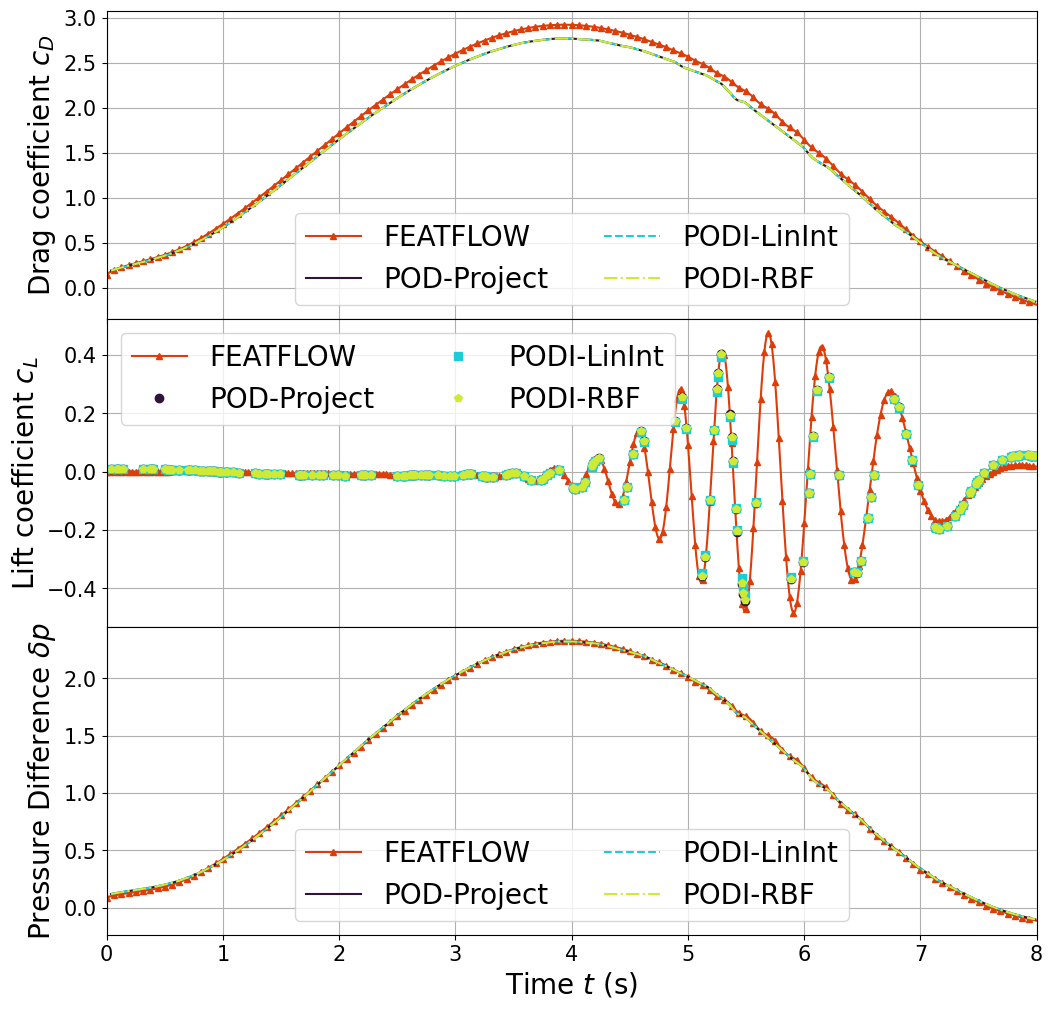

In [39]:
turek = np.loadtxt("./../BenchmarkData/LaminarNS_DFG2/bdforces_lv4.txt")
turek_p = np.loadtxt("./../BenchmarkData/LaminarNS_DFG2/pointvalues_lv4.txt")

keys = [*list(reconstructions[0].keys())]
colors = cm.turbo(np.linspace(0., 0.85, len(keys)+1))
markers_styles = ['o', 's', 'p', 'd']
line_styles = ['-', '--', '-.', ':']

fig, axs = plt.subplots(3,1, sharex=True, figsize=(12, 12))

# Drag Coefficient
axs[0].plot(turek[1:,1], turek[1:,3], "-^", color=colors[-1], markevery=100, markersize=5, label="FEATFLOW")
for kk in range(len(keys)):
    axs[0].plot(QoI_data[kk]['t_u'], QoI_data[kk]['C_D'], line_styles[kk], color=colors[kk], label=keys[kk])

# Lift Coefficient
axs[1].plot(turek[1:,1], turek[1:,4], "-^", color=colors[-1], markevery=50, markersize=5, label="FEATFLOW")
for kk in range(len(keys)):
    axs[1].plot(QoI_data[kk]['t_u'], QoI_data[kk]['C_L'], markers_styles[kk], color=colors[kk], label=keys[kk])

# Pressure Difference
axs[2].plot(turek[1:,1], turek_p[1:,6]-turek_p[1:,-1], "-^", color=colors[-1], markevery=100, markersize=5, label="FEATFLOW")
for kk in range(len(keys)):
    axs[2].plot(QoI_data[kk]['t_p'], QoI_data[kk]['dP'], line_styles[kk], color=colors[kk], label=keys[kk])

axs[0].set_ylabel(r"Drag coefficient $c_D$", fontsize=20)
axs[1].set_ylabel(r"Lift coefficient $c_L$", fontsize=20)
axs[2].set_ylabel(r"Pressure Difference $\delta p$", fontsize=20)

axs[2].set_xlabel(r"Time $t$ (s)", fontsize=20)
axs[2].set_xlim(0,T)
for ax in axs:
    ax.grid()
    ax.legend(fontsize=20, ncols=2)
    ax.tick_params(axis='both', labelsize=15)

fig.subplots_adjust(hspace = 0.0, wspace=0.0)

In the end, the contour plots of the different reconstruction algorithms can be generated using a function implemented in `contour_plotting.py`.

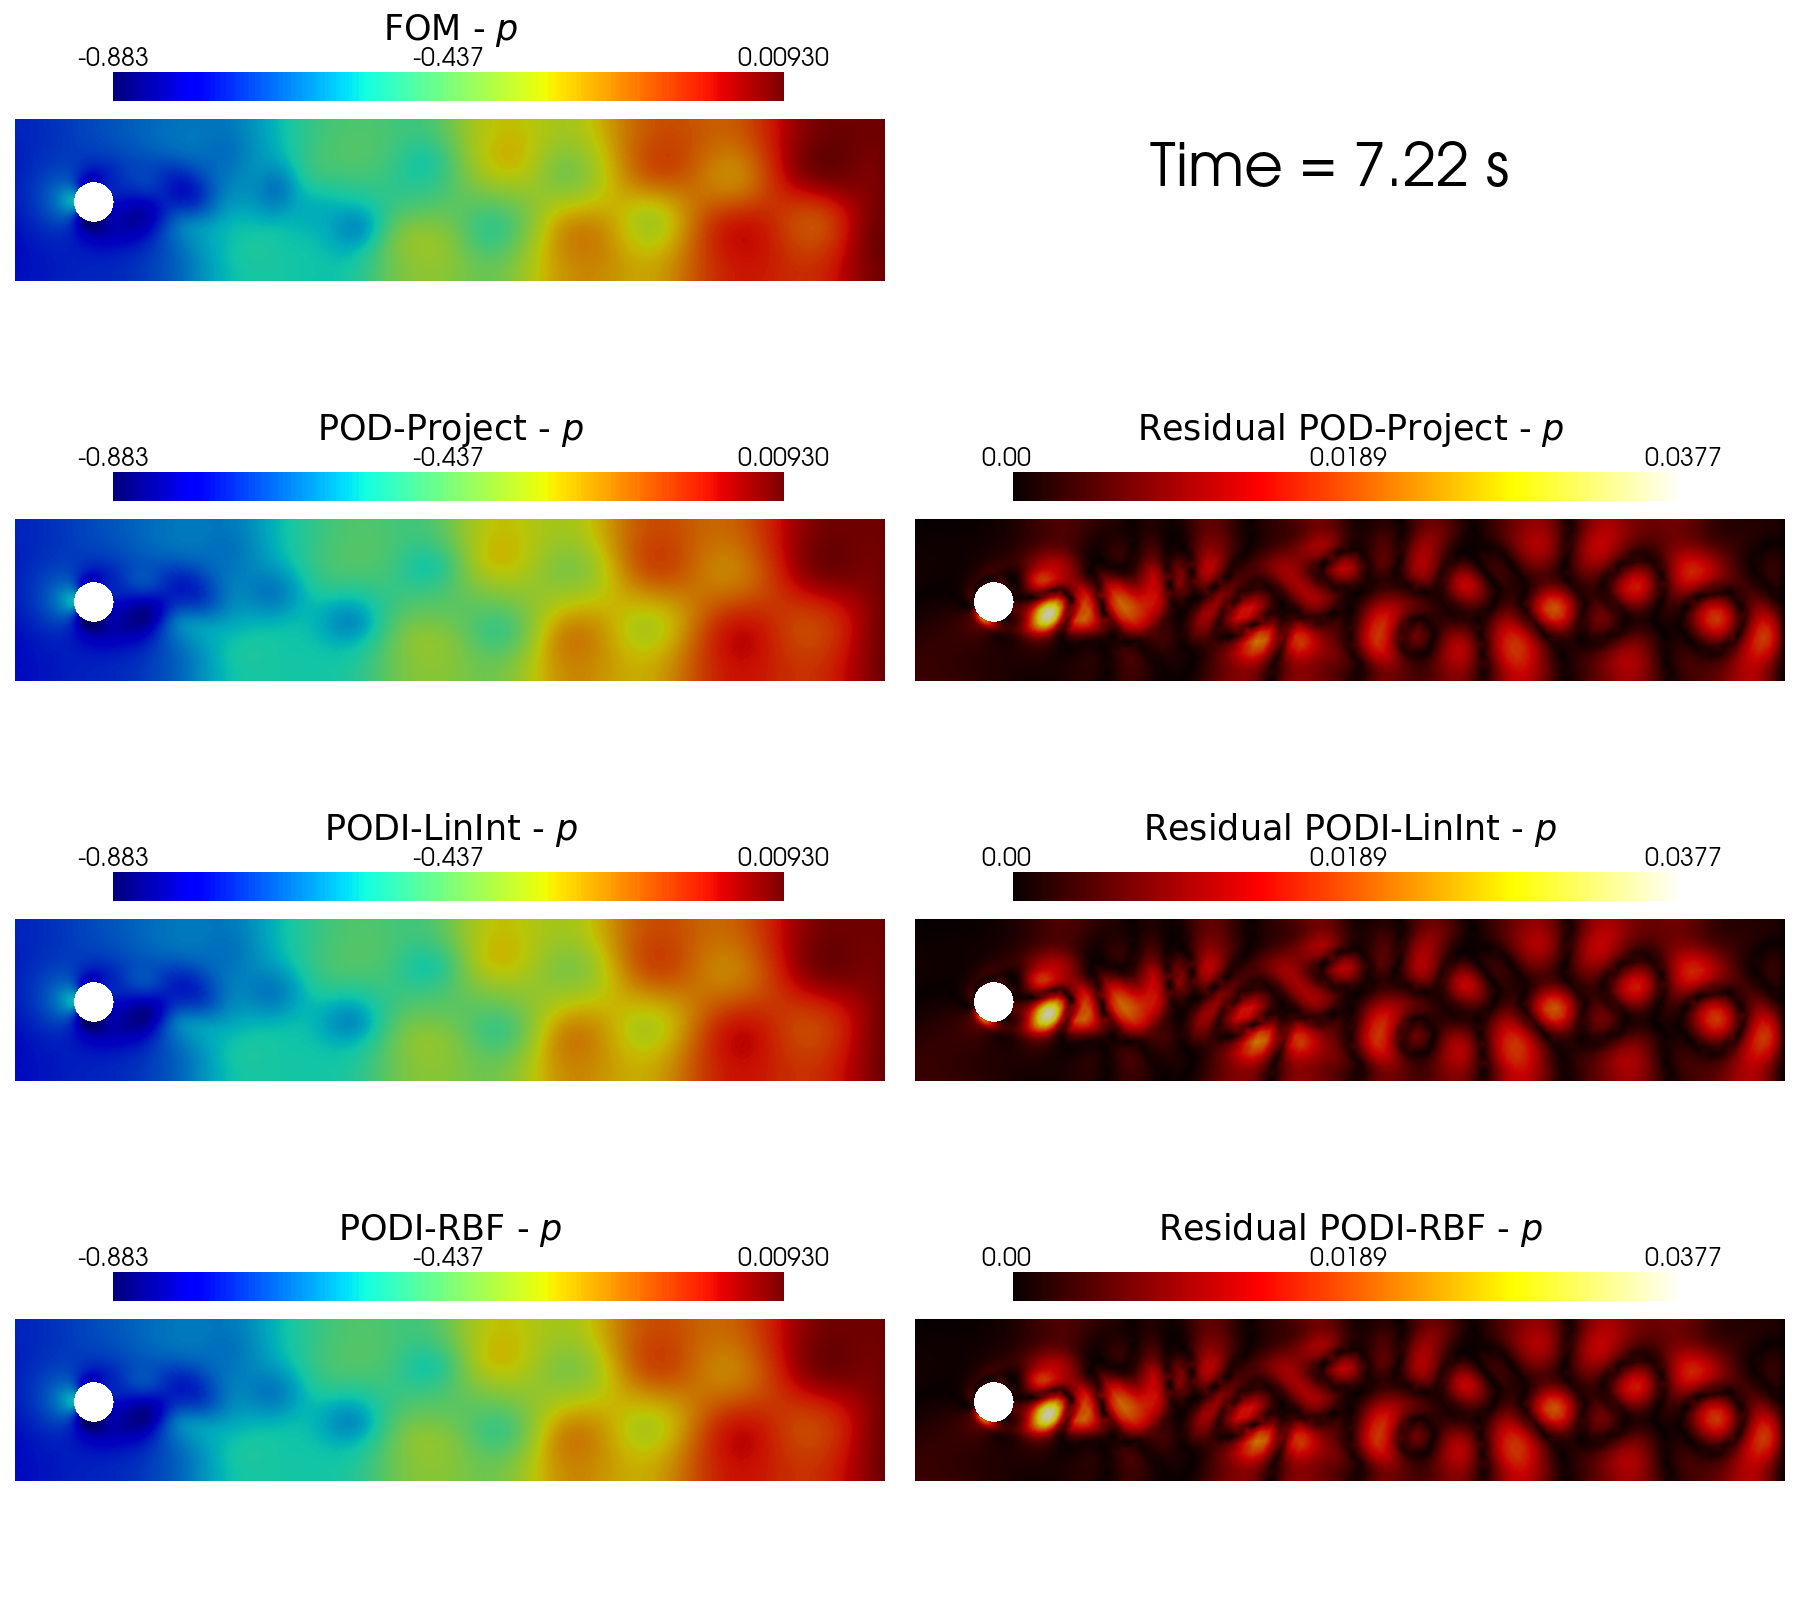

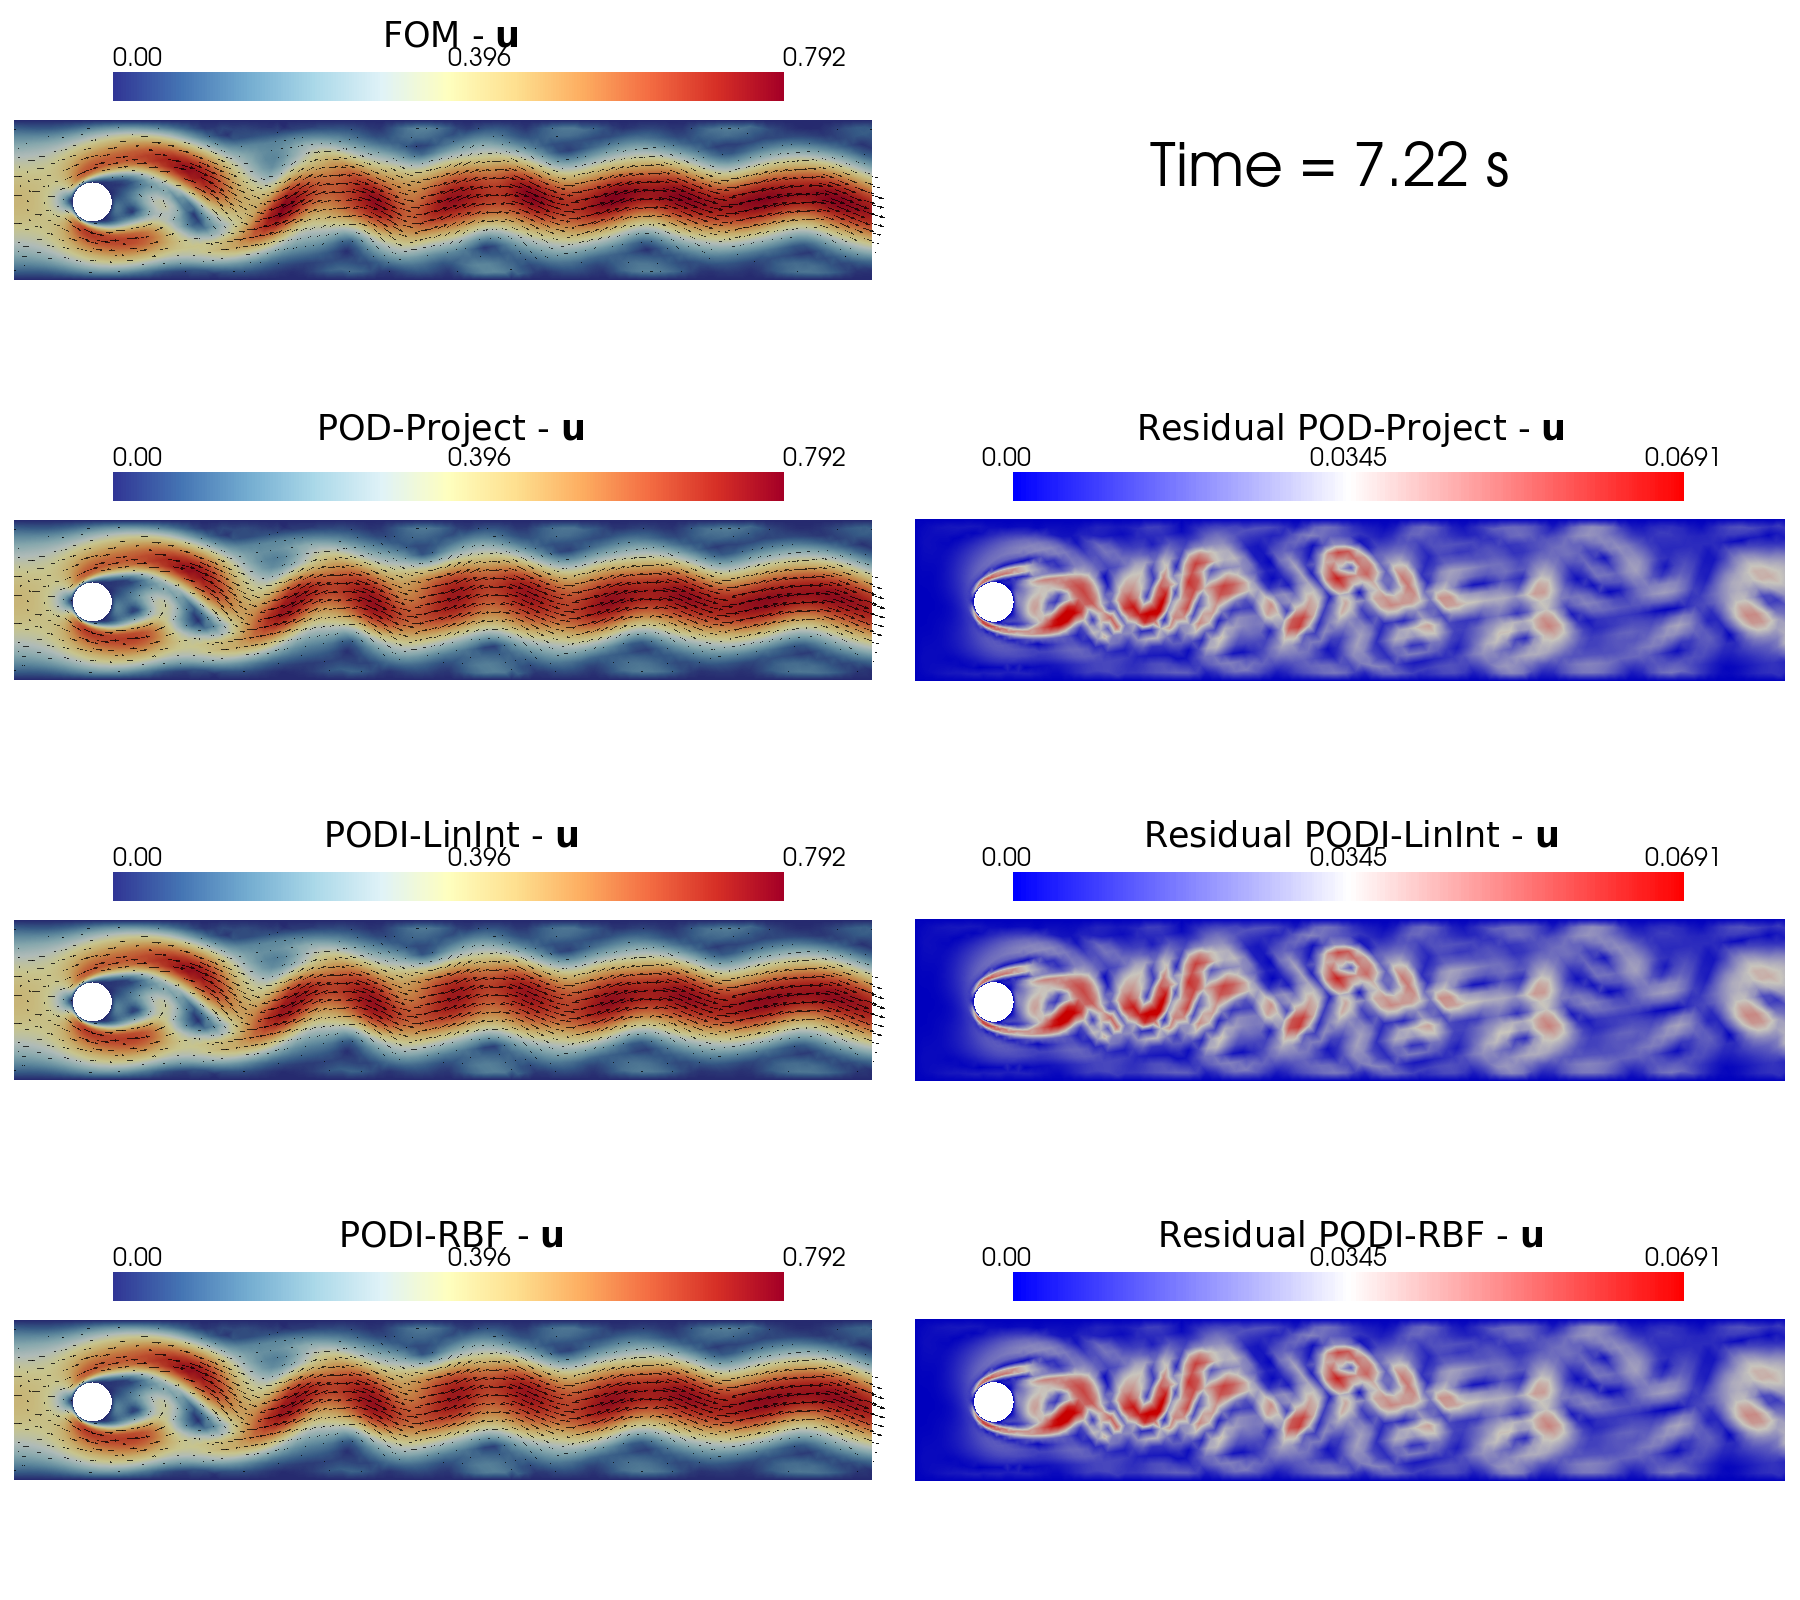

In [60]:
from contour_plotting import plot_FOM_vs_ROM

sorted_idx = np.argsort(test_params[0].flatten())

cmaps = [cm.jet, cm.RdYlBu_r]
cmaps_res = [cm.hot, cm.bwr]

tt_plot = sorted_idx[140]

for field_i in range(len(var_names)):
    
    title = 'Time = {:.2f}'.format(test_params[field_i].flatten()[tt_plot])+' s'

    plot_FOM_vs_ROM( test_snaps[field_i], reconstructions[field_i], 
                    tt_plot, title, tex_var_names[field_i],
                    colormap=cmaps[field_i], colormap_res = cmaps_res[field_i],
                    filename=None, mag_plot=False,
                    factor = 0.06, tolerance = 0.01
                    )